<a href="https://colab.research.google.com/github/JinzhenHu/Variational_Autoencoder/blob/main/VAE_Jinzhen_Hu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder Implementation


*   Applicant Jinzhen Hu



# 1. General Understanding of Variational Autoencoder (VAE)




**1.1 forward step of VAE**

$Dataset: N\times D$

$Batch\hspace{0.2cm}size:B$

$Latent\hspace{0.2cm} dimension:L$

Take data point $x$ with the shape $(B,D)$ as the input into encoder and let the encoder learn the parameters($\phi\in\mathbb{R}^{L*2},\phi=\{μ,σ\}$) of the posterior distribution $q(z|x, \phi)$ over latent variable $z$. By reparameterization trick, sampling from a simpler distribution, $\epsilon \sim \operatorname{N(0,1)}$and transformed the sample with a deterministic function into $z=E(z)+ϵ\odot\sqrt{V(z)}  $, which the decoder then uses to reconstruct the original data point. The neural network's weights are updated and optimized by backpropagating the error signal, minimizing the loss function which composed a reconstruction loss and KL divergence.


**1.2 how to generate new samples**

In a Variational Autoencoder (VAE), the decoder has the capability to generate new data samples. After training the VAE, we can sample a latent variable $z$ from the prior distribution, which is typically a standard Gaussian. This sampled $z$ is then used as an input to the decoder. Consequently, we can generate new data points from the decoder, without needing any specific input data points.

**1.3 how to generate new samples similar to a specific input sample**

To reconstruct a specific input using a trained Variational Autoencoder (VAE), first pass the input through the encoder, which outputs the parameters of the posterior distribution (typically the mean and variance). Next, reparameterize a new epsilon sampled from a standard Gaussian distribution to obtain the latent variables. Finally, feed these latent variables into the trained decoder, which generates the reconstructed data. The reconstructed data should be similar to the original input, as both are drawn from the same underlying distribution.

# 2. Number of cells, cell types, and genes are in this dataset

In [ ]:
!pip install anndata
!pip install scanpy
!pip install scikit-learn
!pip install kmeans-pytorch
import scanpy as sc
from anndata import read_h5ad
import torch
import numpy as np
import pandas as pd
import anndata as ad
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import umap.umap_ as umap
from sklearn.preprocessing import LabelEncoder
import numpy as np
from kmeans_pytorch import kmeans
from sklearn.metrics.cluster import adjusted_rand_score
import numpy
from sklearn.cluster import KMeans
import numpy as np
import warnings

**2.1 Load the dataset**

In [372]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/DingLab')
data = read_h5ad('cortex.h5ad')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [373]:
#Cell Number
cell_type4 = len(data.obs['cell_ids'].unique())
print("Cell Number:",cell_type4)
#Cells label1
cell_type = len(data.obs['label'].unique())
print("Cell Type:",cell_type)
#Cells label2
cell_type2 = len(data.obs['label2'].unique())
print("Cell Type2:",cell_type2)
#Genes Number
print("Genes Number:",len(data.X[1]))
#Genes Type
gene_type3 = len(data.var['genes'].unique())
print("Gene Type:",gene_type3)

Cell Number: 3005
Cell Type: 7
Cell Type2: 48
Genes Number: 19972
Gene Type: 19970


The dataset consists of 3005 cells. There are 7 unique cell types in the first label and 48 unique cell types in the second label, making a total of 55 different cell types represented in the dataset.

The dataset also contains gene expression for each cell, with a total of 19972 genes profiled. However, upon closer inspection, there are only 19970 unique types of genes in the dataset.

# 3. Preprocess the data

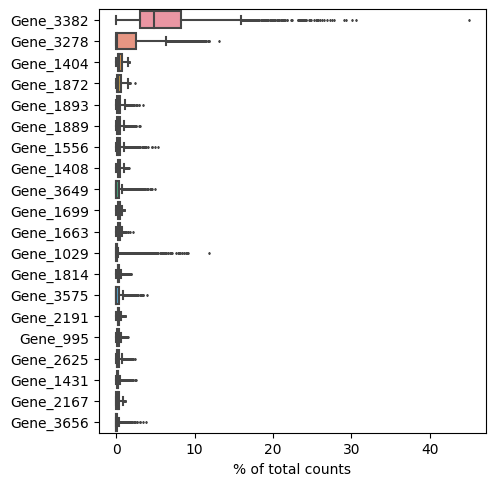

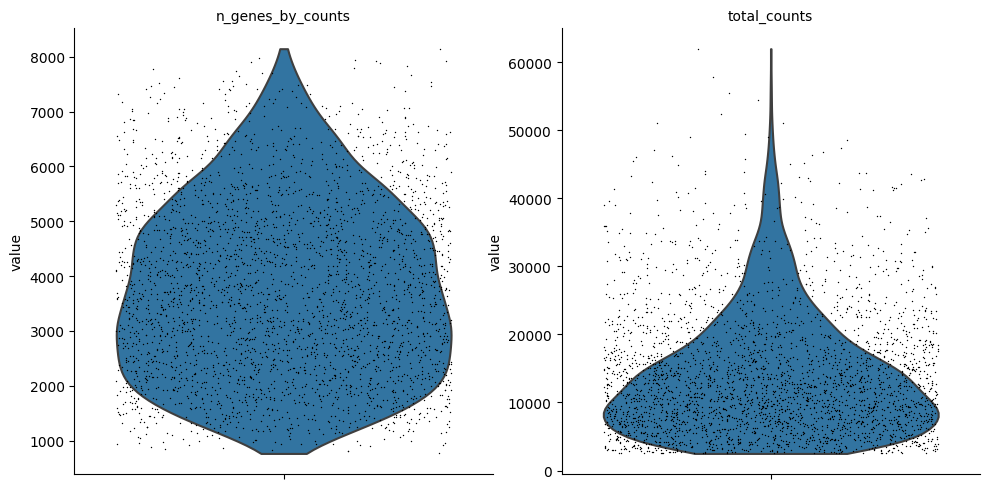

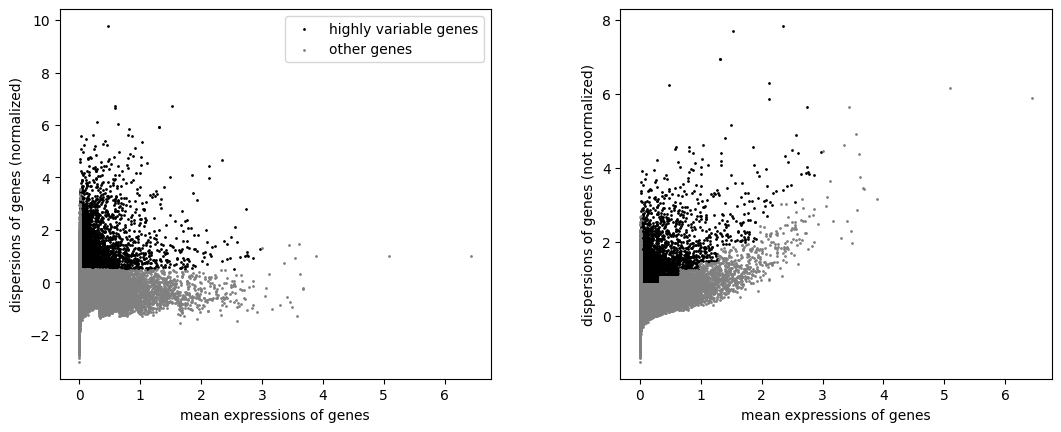

In [374]:
#Preprocess  Dataset

#names the rows and columns
data.obs_names = [f"Cell_{i:d}" for i in range(data.n_obs)]
data.var_names = [f"Gene_{i:d}" for i in range(data.n_vars)]
#Get the numerical_labels
label_counts = data.obs['label'].value_counts()
label_encoder = LabelEncoder()
numerical_labels = torch.tensor(label_encoder.fit_transform(data.obs['label'].values))


#Show those genes that yield the highest fraction of counts in each single cell
sc.pl.highest_expr_genes(data, n_top=20,)
print("\n")

#filter genes that appear less than 3 cells
sc.pp.filter_genes(data, min_cells=3)
#add new meta data a).total counts of genes expression in each cell;
#b).number of genes that are detected as expression in each cell
sc.pp.calculate_qc_metrics(data, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(data, keys=['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)
print("\n")

#Normalize the difference in gene expression between each cell can be accurately measured and compared
sc.pp.normalize_total(data, target_sum=1e4)
#Logarithmize the data
sc.pp.log1p(data)
#Identify highly-variable genes
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(data)

# 4. Implement VAE on cortex dataset

In [644]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**4.1 Define the model**

In [645]:
#Define the Model
input_dim=18879
latent_dim=45


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim ** 2),
            nn.ReLU(),
            nn.Linear(latent_dim ** 2, latent_dim * 2),
            nn.ReLU(), 
            nn.Linear(latent_dim * 2, latent_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim * 2),
            nn.ReLU(),  
            nn.Linear(latent_dim * 2, latent_dim ** 2),
            nn.ReLU(),
            nn.Linear(latent_dim ** 2, input_dim)
        )
    def reparameterise(self, mu, logvar):
            std = logvar.mul(0.5).exp()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)


    def forward(self, x):
        mu_logvar = self.encoder(x.view(x.size(0),input_dim)).view(x.size(0), 2, latent_dim)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar



**4.2 Define the Data**

In [646]:
# Define the Data
model = VAE().to(device)
class GeneDataset(Dataset):
    def __init__(self,data_matrix,labels):
        self.data = torch.tensor(data_matrix,dtype=torch.float32)
        self.label = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = self.label[idx]
        return x, y

BATCH_SIZE = 64
train_length = int(len(data) * 0.8)
test_length = len(data) - train_length
full_dataset = GeneDataset(data.X,numerical_labels)
train_dataset, test_dataset = random_split(full_dataset, [train_length, test_length])
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False
 )
full_dataset.data = full_dataset.data.to(device)


# Define the Loss Function
def loss_function(x, x_recon, mu, logvar, a=1):
    recon_loss = (nn.MSELoss(reduction='sum')(x_recon, x.view(x.size(0),input_dim)))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + a* KLD

# Define the optimizer
learning_rate = 0.8e-3
optimizer = torch.optim.Adam(
     model.parameters(),
    lr=learning_rate
 )



**4.3 Training and Testing Model**

====> Epoch: 1 Average loss: 42.4378
====> Epoch: 1 Average Test loss: 36.7753


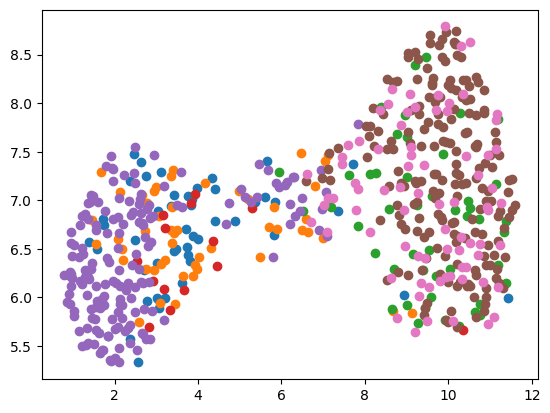

====> Epoch: 2 Average loss: 33.3460
====> Epoch: 2 Average Test loss: 34.2933


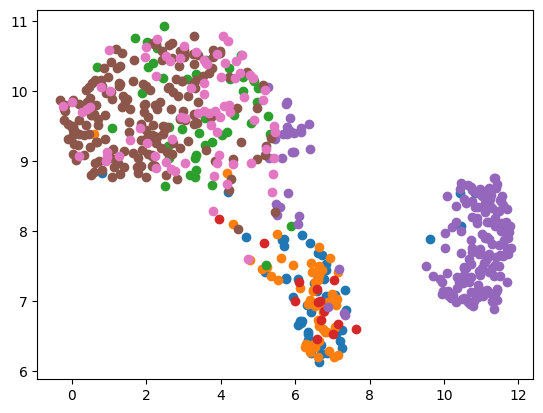

====> Epoch: 3 Average loss: 31.6013
====> Epoch: 3 Average Test loss: 33.1232


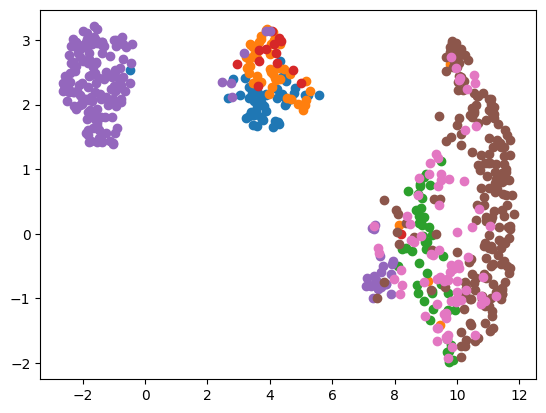

====> Epoch: 4 Average loss: 30.5265
====> Epoch: 4 Average Test loss: 31.9055


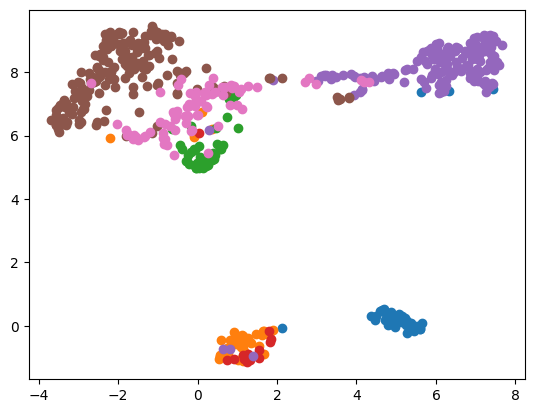

====> Epoch: 5 Average loss: 29.7547
====> Epoch: 5 Average Test loss: 31.4518


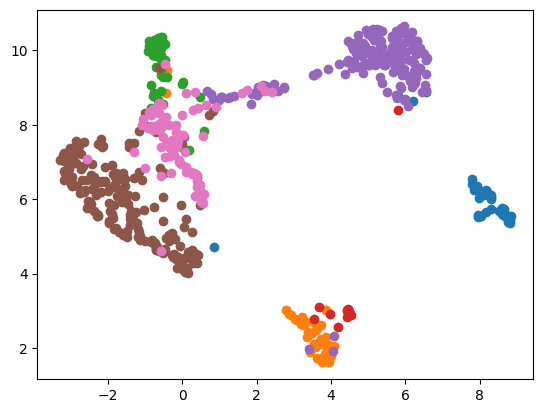

====> Epoch: 6 Average loss: 29.2457
====> Epoch: 6 Average Test loss: 31.0507


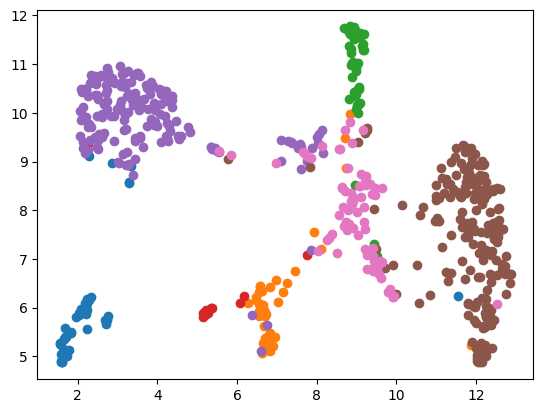

====> Epoch: 7 Average loss: 28.9389
====> Epoch: 7 Average Test loss: 31.1436


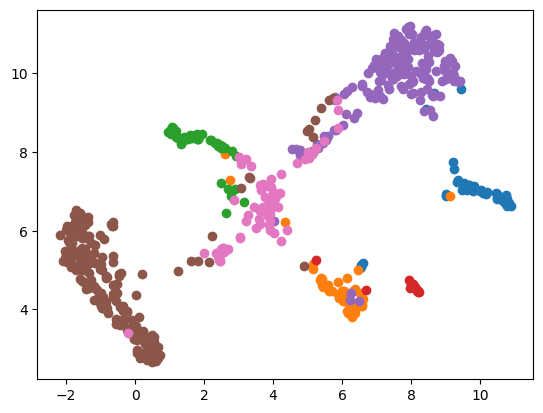

====> Epoch: 8 Average loss: 28.6876
====> Epoch: 8 Average Test loss: 30.9236


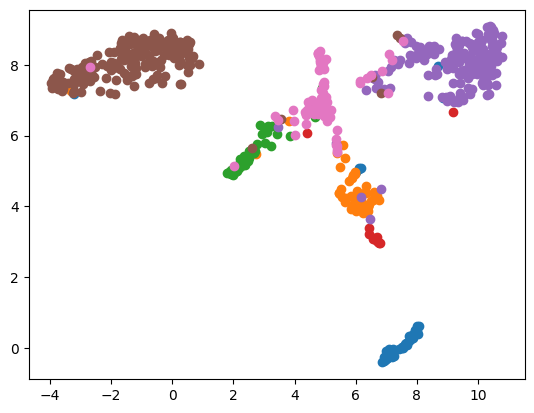

====> Epoch: 9 Average loss: 28.5072
====> Epoch: 9 Average Test loss: 30.5337


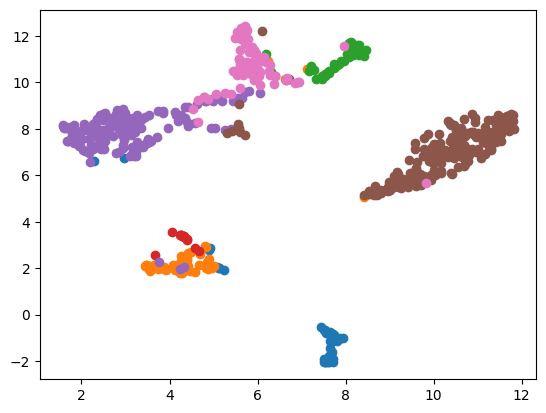

====> Epoch: 10 Average loss: 28.3158
====> Epoch: 10 Average Test loss: 30.5425


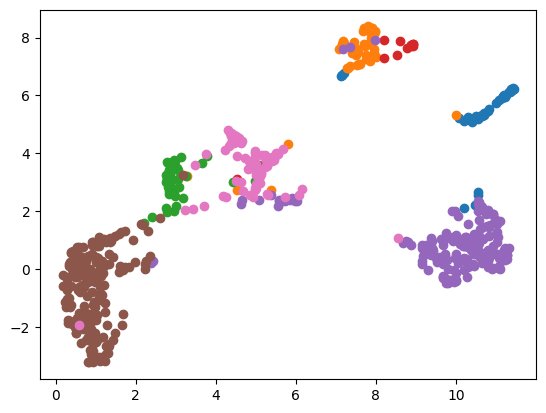

====> Epoch: 11 Average loss: 28.1351
====> Epoch: 11 Average Test loss: 30.2346


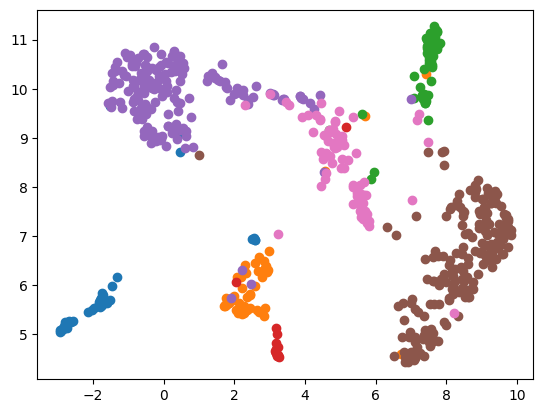

====> Epoch: 12 Average loss: 27.9346
====> Epoch: 12 Average Test loss: 30.3585


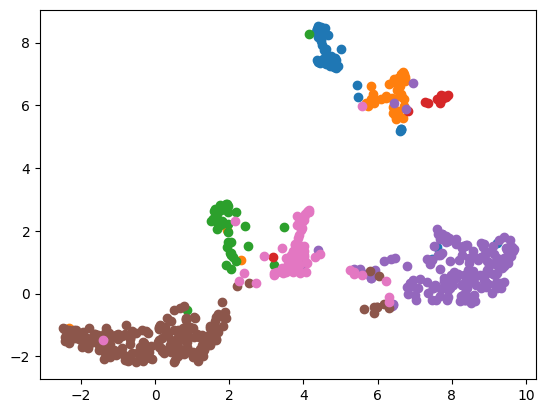

====> Epoch: 13 Average loss: 27.8031
====> Epoch: 13 Average Test loss: 30.1927


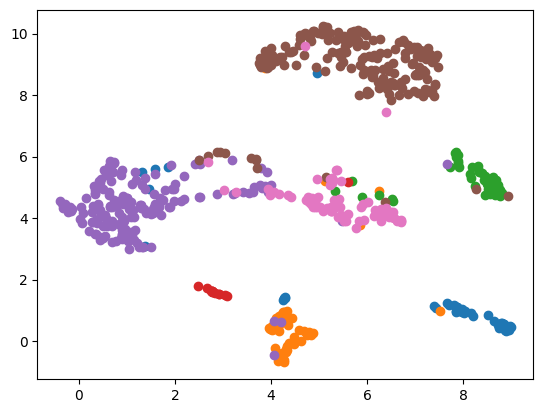

====> Epoch: 14 Average loss: 27.6097
====> Epoch: 14 Average Test loss: 30.2138


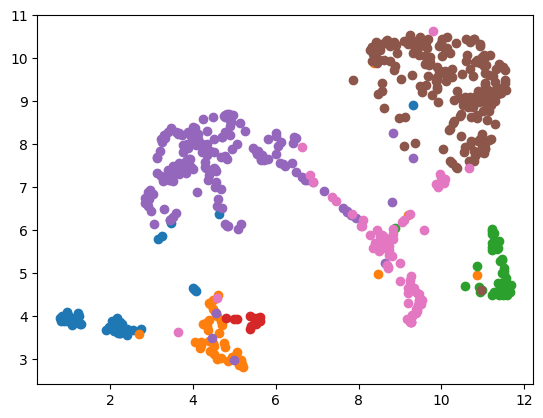

====> Epoch: 15 Average loss: 27.4621
====> Epoch: 15 Average Test loss: 29.9543


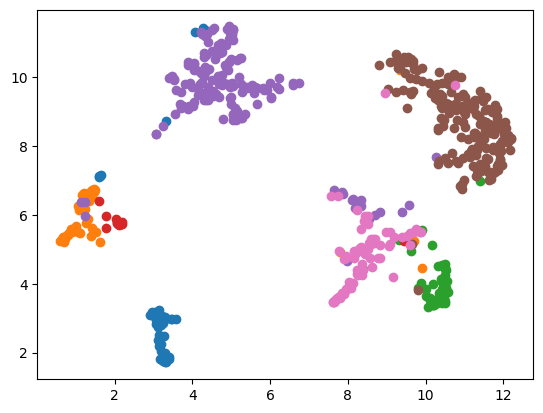

====> Epoch: 16 Average loss: 27.2618
====> Epoch: 16 Average Test loss: 29.9345


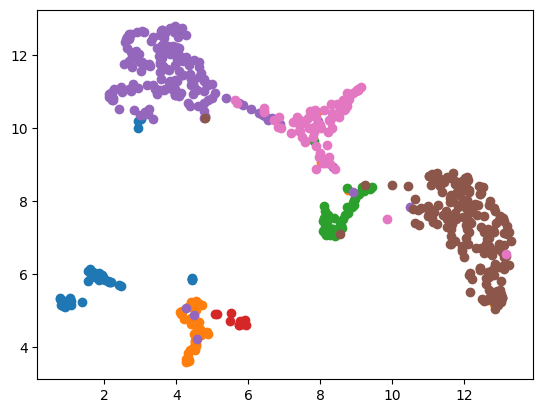

====> Epoch: 17 Average loss: 27.1267
====> Epoch: 17 Average Test loss: 30.1745


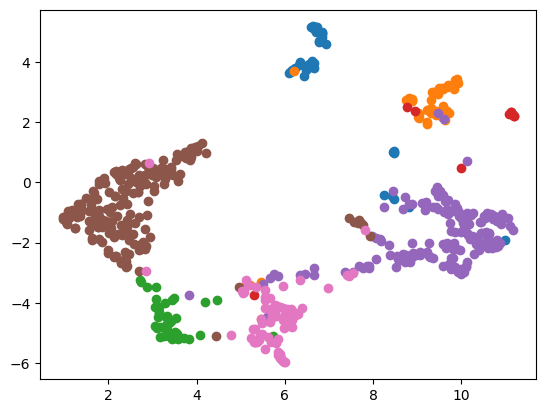

====> Epoch: 18 Average loss: 26.9947
====> Epoch: 18 Average Test loss: 29.9907


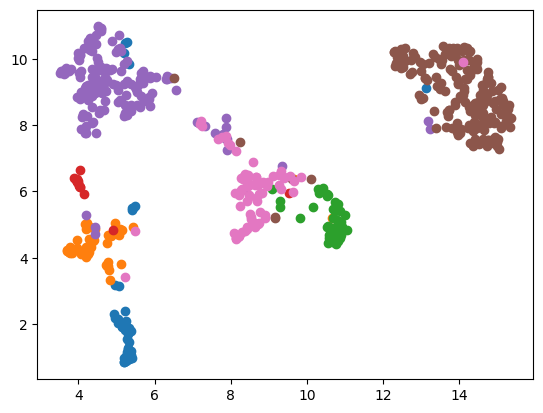

====> Epoch: 19 Average loss: 26.7937
====> Epoch: 19 Average Test loss: 29.8705


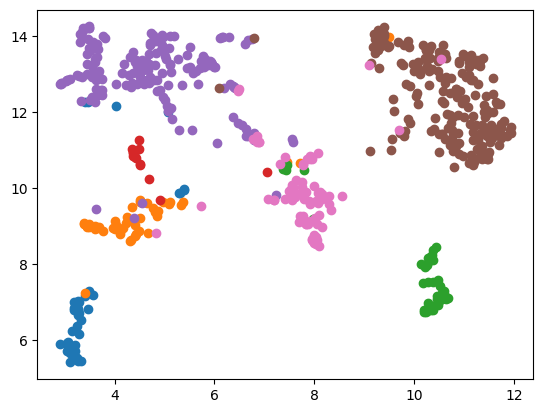

====> Epoch: 20 Average loss: 26.5857
====> Epoch: 20 Average Test loss: 30.0623


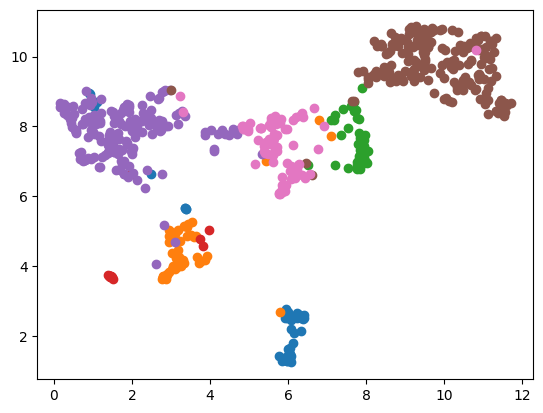

====> Epoch: 21 Average loss: 26.5131
====> Epoch: 21 Average Test loss: 29.9216


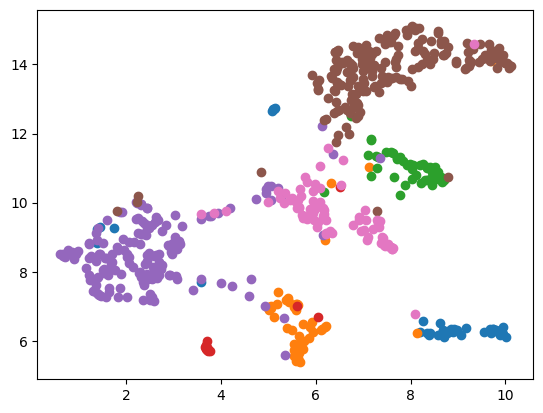

====> Epoch: 22 Average loss: 26.3390
====> Epoch: 22 Average Test loss: 29.8469


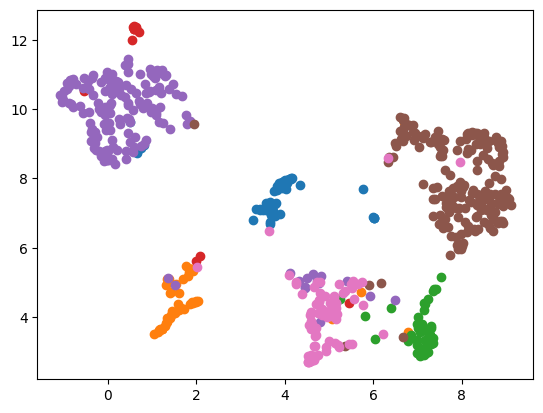

====> Epoch: 23 Average loss: 26.1657
====> Epoch: 23 Average Test loss: 30.0516


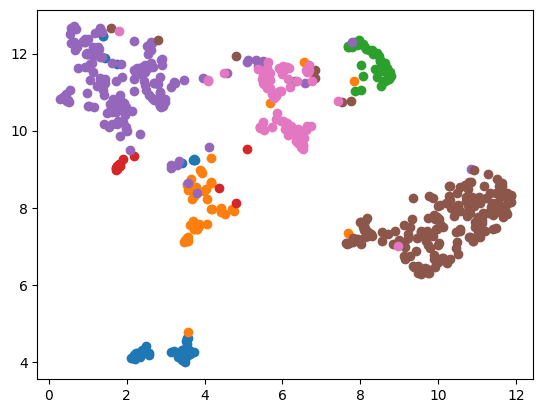

====> Epoch: 24 Average loss: 25.9741
====> Epoch: 24 Average Test loss: 29.9945


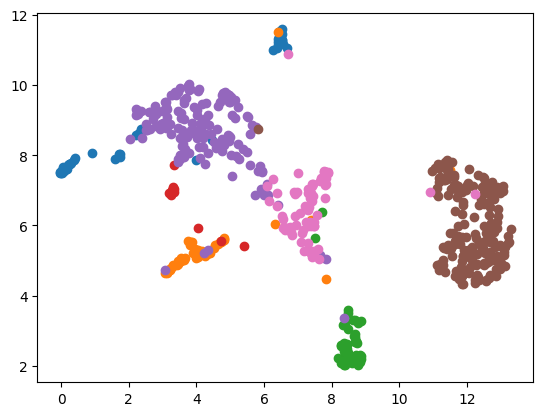

====> Epoch: 25 Average loss: 25.7789
====> Epoch: 25 Average Test loss: 29.9479


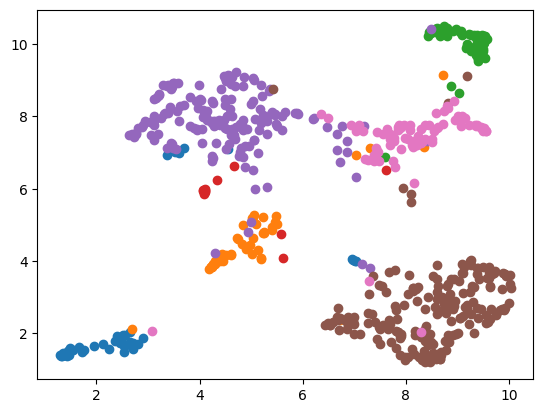

====> Epoch: 26 Average loss: 25.6000
====> Epoch: 26 Average Test loss: 30.5014


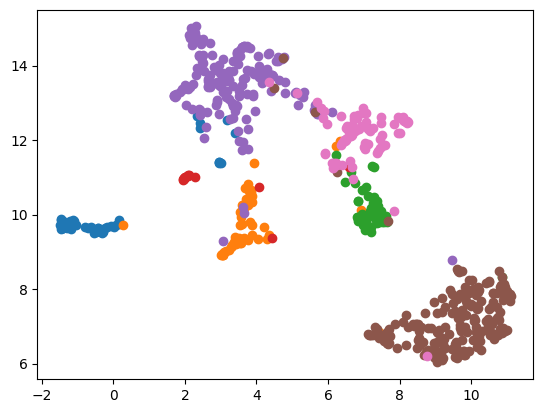

====> Epoch: 27 Average loss: 25.3970
====> Epoch: 27 Average Test loss: 30.2246


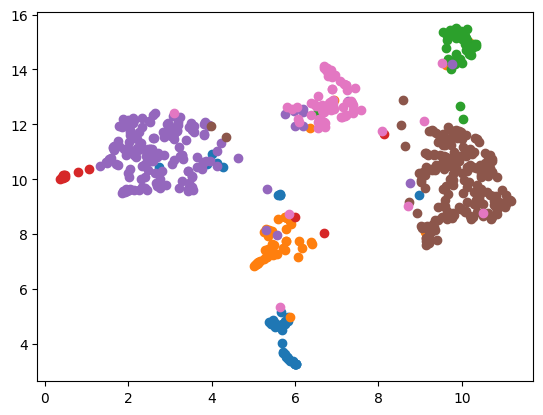

====> Epoch: 28 Average loss: 25.1527
====> Epoch: 28 Average Test loss: 30.3955


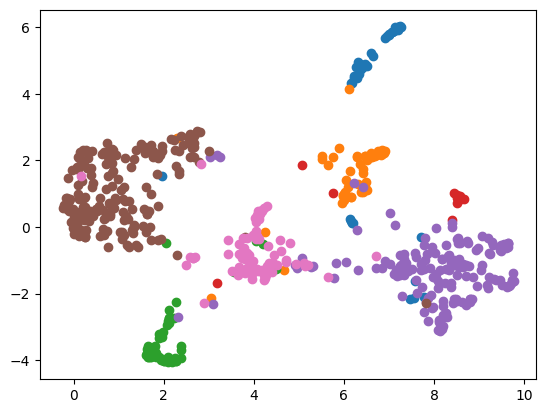

====> Epoch: 29 Average loss: 24.9867
====> Epoch: 29 Average Test loss: 30.2469


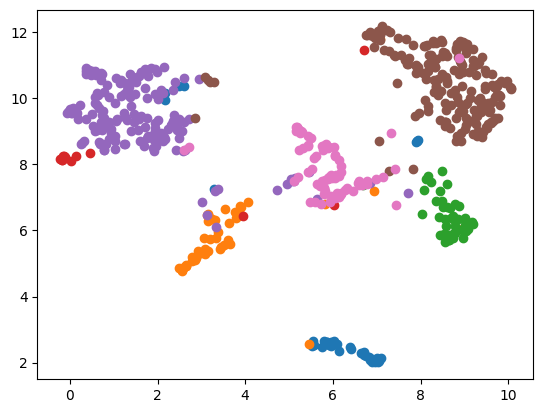

====> Epoch: 30 Average loss: 24.7129
====> Epoch: 30 Average Test loss: 30.3843


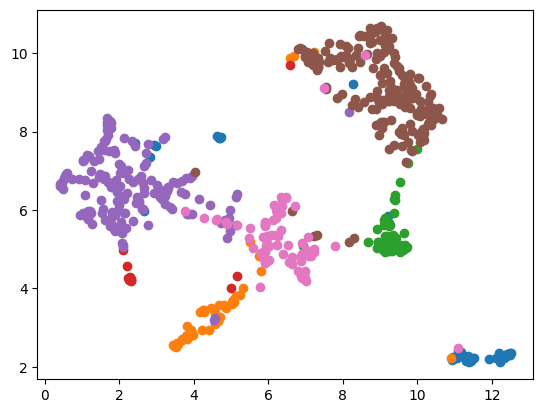

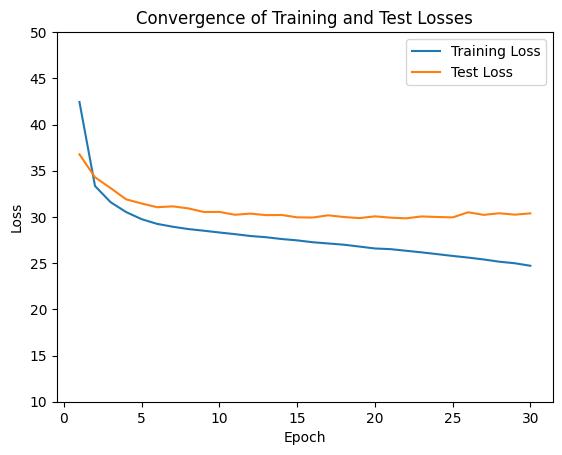

torch.Size([25, 18879])


In [647]:
#Train the model
epochs = 30
train_losses = []
test_losses = []
min_test_loss = float('inf')
for epoch in range(0, epochs + 1):
     if epoch > 0:
        model.train()
        train_loss = 0
        for x,_ in train_loader:
             x = x.to(device)
             x_recon, mu, logvar = model(x)
             loss = loss_function(x, x_recon, mu, logvar)
             train_loss += loss.item()/x.size(0)
             optimizer.zero_grad()
             loss.backward()
             optimizer.step()
        train_losses.append(train_loss / len(train_dataset))    
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_dataset):.4f}')

           
#Test the Model
        def test_vae(model, test_loader, device, loss_function):
          with torch.no_grad():
            model.eval()
            test_loss = 0
            reconstruction = []
            mus = []
            logvars = []
            labels = []
            for x,y in test_loader:
              x = x.to(device)
              x_recon,mu,logvar = model(x)
              loss = loss_function(x, x_recon, mu, logvar)
              test_loss += loss.item()/x.size(0)
              reconstruction.append(x_recon.cpu().detach().numpy())
              mus.append(mu.cpu().detach().numpy())
              logvars.append(logvar.cpu().detach().numpy())
              labels.append(y.cpu().detach().numpy())
            test_loss /= len(test_dataset)
            return test_loss,reconstruction,mus,logvars 
   
        test_loss, reconstruction, mus, logvars = test_vae(model, test_loader, device, loss_function)
        test_losses.append(test_loss)  
        #Save the best weight
        if test_loss < min_test_loss:
          min_test_loss = test_loss
          best_epoch = epoch
          best_weights = model.state_dict()
          torch.save(model.state_dict(),"best_model_weights.pth1")
        print(f'====> Epoch: {epoch} Average Test loss: {test_loss:.4f}')

#Extract Latent
        model.eval()
        latent = []
        labels = []
        with torch.no_grad():
          for x,y in test_loader:
            x = x.to(device)
            x_recon, mu, logvar = model.forward(x)
            # Sample z using the reparameterization trick
            z = model.reparameterise(mu, logvar)
            labels.append(y.cpu().detach().numpy())
            latent.append(z)

#UMAP for visualizing in 2D

          latent_1 = torch.cat(latent,dim=0)
          latent_2 = latent_1.cpu().numpy()
          fit = umap.UMAP()
          embeddings = fit.fit_transform(latent_2)
          unique_labels = np.unique(np.concatenate(labels))
          for label in unique_labels:
            indices = np.where(np.concatenate(labels) == label)
            plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=label)

          plt.show()  
       
#Plot the Convergence
print("\n")
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Convergence of Training and Test Losses")
plt.ylim(10, 50) 
plt.show()
print(x.shape)

**4.4 Visualize latent variable using UMAP**

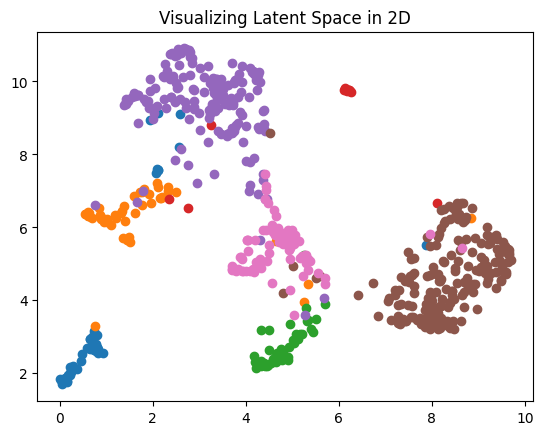

Average test loss at best weights: 29.9173875328229


In [654]:
#Load the neural networks with best weights and plot the latent space
model.load_state_dict(torch.load("best_model_weights.pth1"))
model.eval()
test_loss=0
latent = []
labels = []
with torch.no_grad():  
    for x, y in test_loader:
      x = x.to(device)
      x_recon,mu,logvar = model(x)
      loss = loss_function(x, x_recon, mu, logvar)
      labels.append(y.clone().detach().numpy())
      z = model.reparameterise(mu, logvar)
      latent.append(z)
      test_loss += loss.item()/x.size(0)
avg_test_loss = test_loss / len(test_dataset)
latent_1 = torch.cat(latent,dim=0)
latent_2 = latent_1.cpu().numpy()

fit = umap.UMAP()
embeddings = fit.fit_transform(latent_2)
unique_labels = np.unique(np.concatenate(labels))
for label in unique_labels:
  indices = np.where(np.concatenate(labels) == label)
  plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=label)
  plt.title("Visualizing Latent Space in 2D")
  
plt.show()
print(f'Average test loss at best weights: {avg_test_loss}')   

# 5.Run K-Means and explore Adjusted Rand Index(ARI) Score

**5.1 Implementing K-means on latent variables**

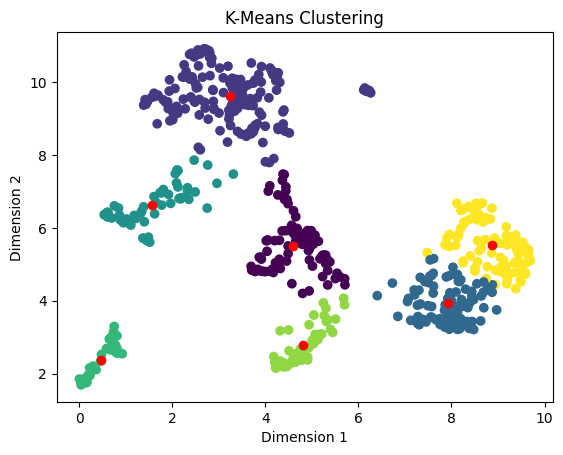

In [655]:
#K-means Implementation 
num_clusters = 7

kmeans= KMeans(
    n_clusters=num_clusters, n_init=10).fit(embeddings)

plt.scatter(embeddings[:,0],embeddings[:,1],c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c = "red")

plt.title("K-Means Clustering")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

**5.2 ARI score on latent variables with its mean and variance**

In [658]:
n_runs = 20
ari_score = []
num_clusters = 7
warnings.filterwarnings("ignore")
for _ in range(n_runs):
  model.load_state_dict(torch.load("best_model_weights.pth2"))
  model.eval()
  test_loss=0
  latent = []
  labels = []
  with torch.no_grad():  
      for x, y in test_loader:
        x = x.to(device)
        x_recon,mu,logvar = model(x)
        labels.append(y.clone().detach().numpy())
        z = model.reparameterise(mu, logvar)
        latent.append(z)
  latent_1 = torch.cat(latent,dim=0)
  latent_2 = latent_1.cpu().numpy()
  fit = umap.UMAP()
  embeddings = fit.fit_transform(latent_2)
  labels_np=np.concatenate(labels)
  kmeans= KMeans(
      n_clusters=num_clusters, n_init=10).fit(embeddings)
  ari=adjusted_rand_score(kmeans.labels_,labels_np)
  ari_score.append(ari)

ari_score = np.array(ari_score)
mean_ari = np.mean(ari_score)
std_ari = np.std(ari_score)

print(f"Average ARI over {n_runs} runs: {mean_ari}")
print(f"Standard deviation of ARI over {n_runs} runs: {std_ari}")

Average ARI over 20 runs: 0.6656515329079167
Standard deviation of ARI over 20 runs: 0.0257207006784719


## The average ARI score is around ***0.67*** between the ground truth cell types and the labels given by K Means.

# **6.Find highly variable genes and Retrain VAE**

In [664]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**6.1 Plot the highly variable genes(HVGs)**

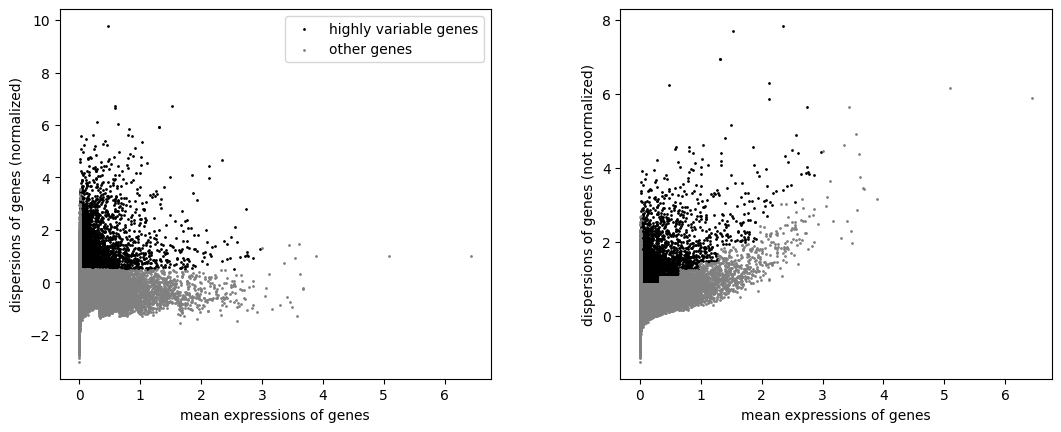

In [665]:
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(data)

**6.2 Train the VAE to give more weight to HVGs**

In [666]:
#Define the Model
input_dim=18879
latent_dim=45


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim ** 2),
            nn.ReLU(),
            nn.Linear(latent_dim ** 2, latent_dim * 2),
            nn.ReLU(), 
            nn.Linear(latent_dim * 2, latent_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim * 2),
            nn.ReLU(),  
            nn.Linear(latent_dim * 2, latent_dim ** 2),
            nn.ReLU(),
            nn.Linear(latent_dim ** 2, input_dim)
        )
    def reparameterise(self, mu, logvar):
            std = logvar.mul(0.5).exp()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)


    def forward(self, x):
        mu_logvar = self.encoder(x.view(x.size(0),input_dim)).view(x.size(0), 2, latent_dim)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


In [667]:
# Define the Data
model = VAE().to(device)
class GeneDataset(Dataset):
    def __init__(self,data_matrix,labels):
        self.data = torch.tensor(data_matrix,dtype=torch.float32)
        self.label = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = self.label[idx]
        return x, y

BATCH_SIZE = 64
train_length = int(len(data) * 0.8)
test_length = len(data) - train_length
full_dataset = GeneDataset(data.X,numerical_labels)
train_dataset, test_dataset = random_split(full_dataset, [train_length, test_length])
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False
 )
full_dataset.data = full_dataset.data.to(device)


**6.2.1 Assign a higher weight to HVGs on reconstruction loss**

In [668]:
# Assign a higher weight to highly variable genes
weights = torch.ones(18879,device=device)
hvg_indices = np.where(data.var['highly_variable'])[0]
weights[hvg_indices] = 2


# Define the Loss Function
def loss_function(x, x_recon, mu, logvar, a=1):
    weight_tensor = weights.expand(x.size(0),-1)
    recon_loss = (nn.MSELoss(reduction='none')(x_recon, x.view(x.size(0),input_dim)))
    weighted_rl = (recon_loss * weight_tensor).sum() 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return weighted_rl + a* KLD

# Define the optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(
     model.parameters(),
    lr=learning_rate
 )


====> Epoch: 1 Average loss: 52.6830
====> Epoch: 1 Average Test loss: 46.3458


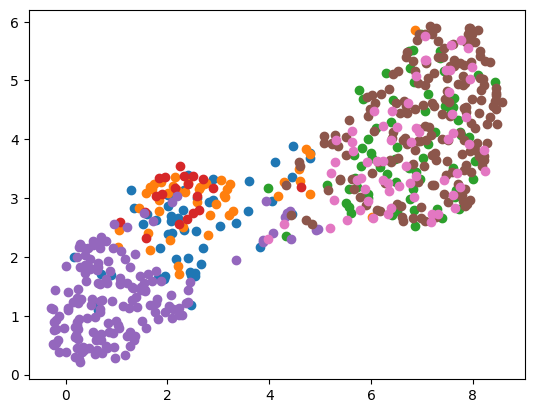

====> Epoch: 2 Average loss: 41.5230
====> Epoch: 2 Average Test loss: 42.7869


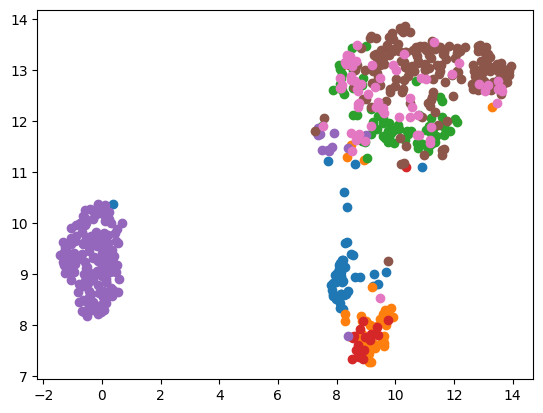

====> Epoch: 3 Average loss: 38.4777
====> Epoch: 3 Average Test loss: 40.3460


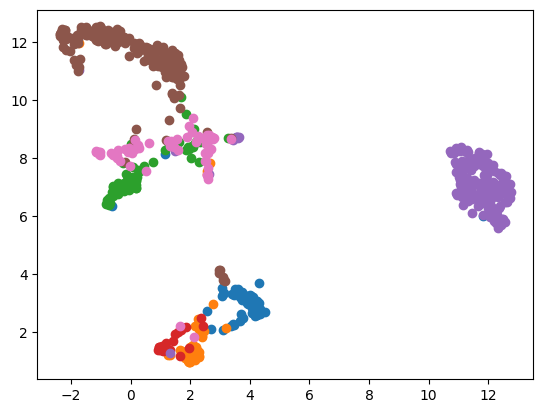

====> Epoch: 4 Average loss: 36.9941
====> Epoch: 4 Average Test loss: 38.9294


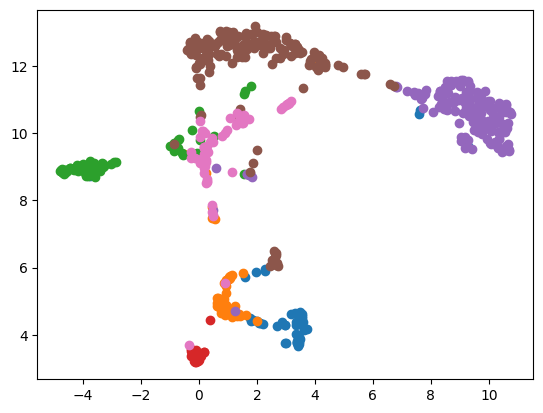

====> Epoch: 5 Average loss: 36.1283
====> Epoch: 5 Average Test loss: 38.7252


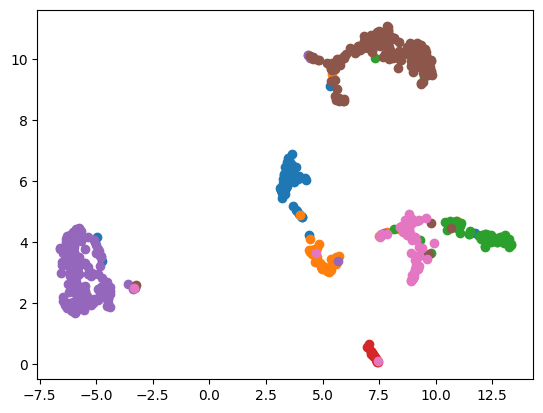

====> Epoch: 6 Average loss: 35.8017
====> Epoch: 6 Average Test loss: 38.9951


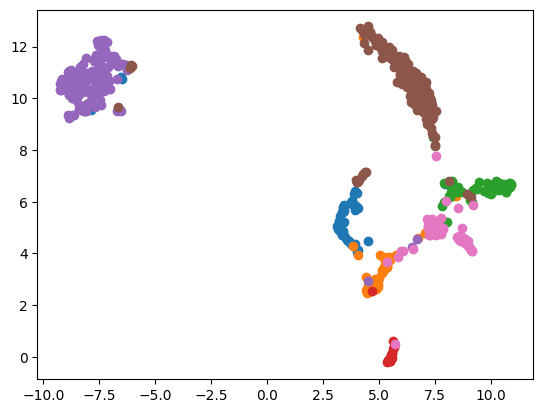

====> Epoch: 7 Average loss: 35.4642
====> Epoch: 7 Average Test loss: 39.0178


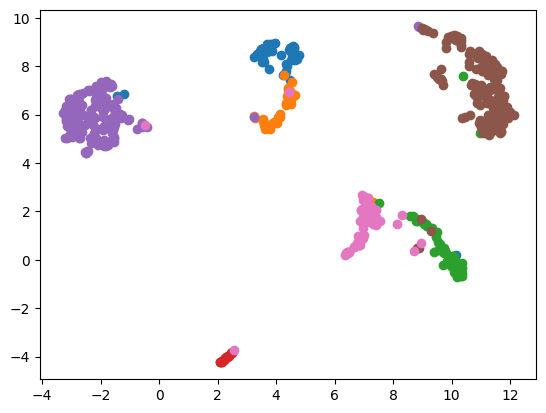

====> Epoch: 8 Average loss: 35.1402
====> Epoch: 8 Average Test loss: 37.8150


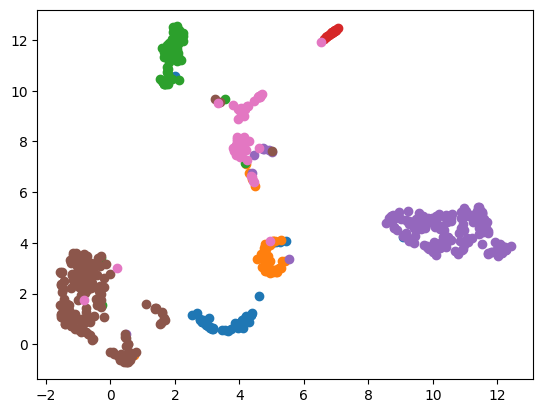

====> Epoch: 9 Average loss: 34.7934
====> Epoch: 9 Average Test loss: 37.8426


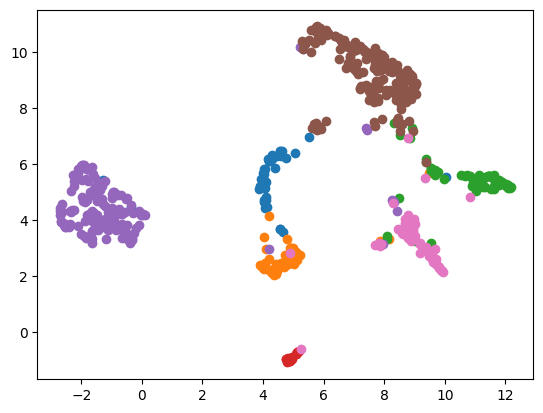

====> Epoch: 10 Average loss: 34.4666
====> Epoch: 10 Average Test loss: 38.1530


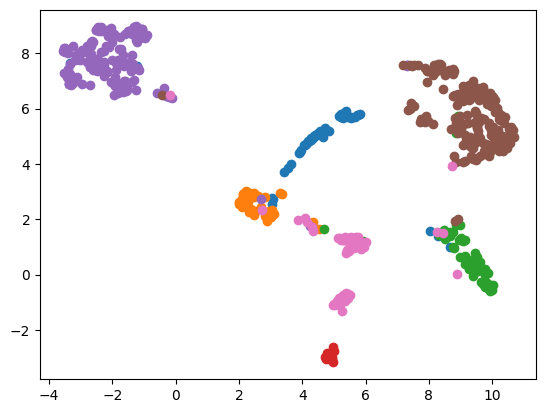

====> Epoch: 11 Average loss: 34.2976
====> Epoch: 11 Average Test loss: 37.6810


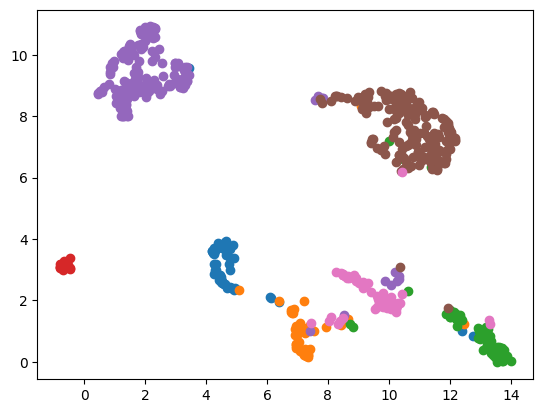

====> Epoch: 12 Average loss: 34.0410
====> Epoch: 12 Average Test loss: 37.0413


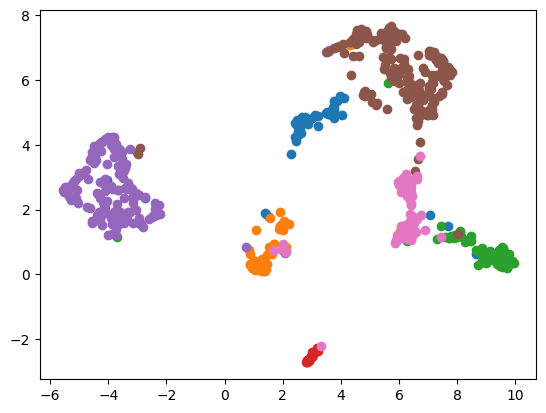

====> Epoch: 13 Average loss: 33.7278
====> Epoch: 13 Average Test loss: 37.4143


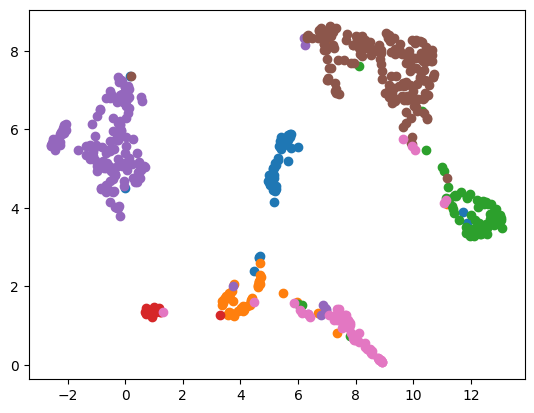

====> Epoch: 14 Average loss: 33.4951
====> Epoch: 14 Average Test loss: 37.3407


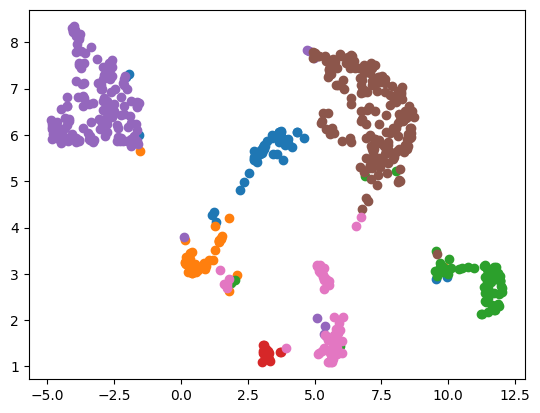

====> Epoch: 15 Average loss: 33.2902
====> Epoch: 15 Average Test loss: 37.3993


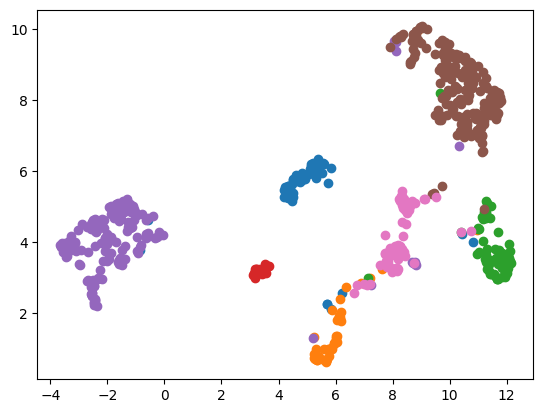

====> Epoch: 16 Average loss: 32.9882
====> Epoch: 16 Average Test loss: 37.2780


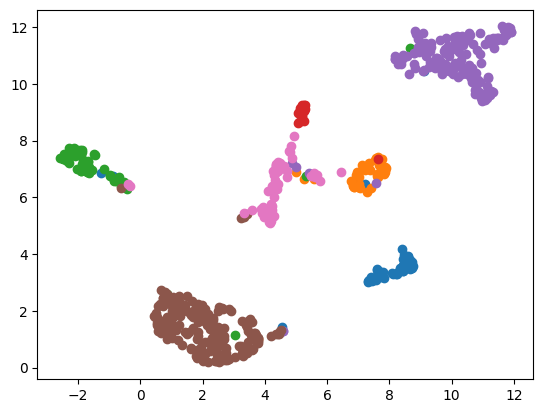

====> Epoch: 17 Average loss: 32.7833
====> Epoch: 17 Average Test loss: 37.1528


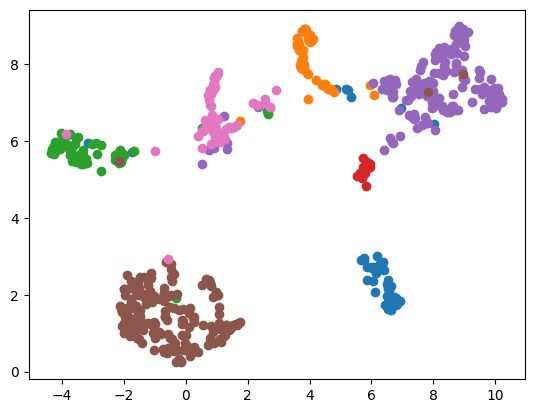

====> Epoch: 18 Average loss: 32.5220
====> Epoch: 18 Average Test loss: 37.1487


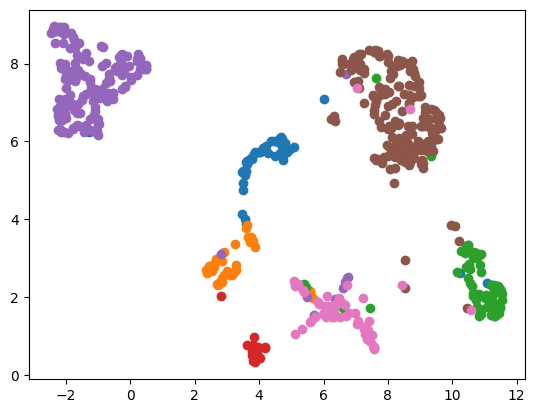

====> Epoch: 19 Average loss: 32.2042
====> Epoch: 19 Average Test loss: 37.4250


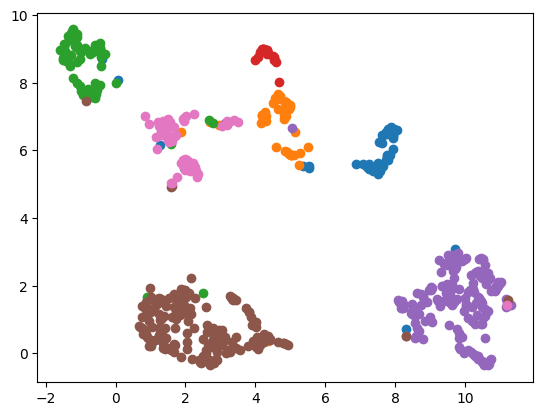

====> Epoch: 20 Average loss: 31.9078
====> Epoch: 20 Average Test loss: 37.3244


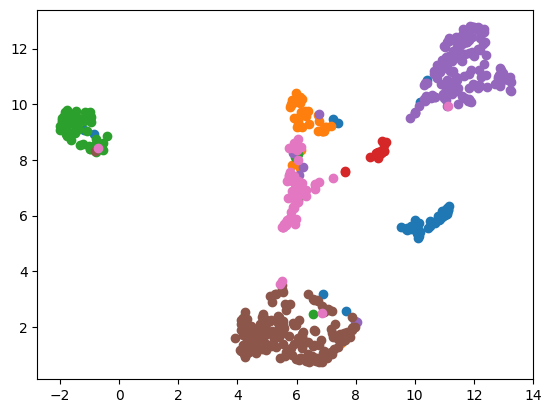

====> Epoch: 21 Average loss: 31.6645
====> Epoch: 21 Average Test loss: 37.3514


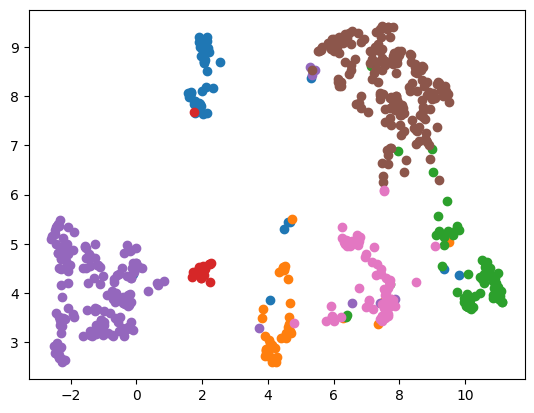

====> Epoch: 22 Average loss: 31.4667
====> Epoch: 22 Average Test loss: 37.6300


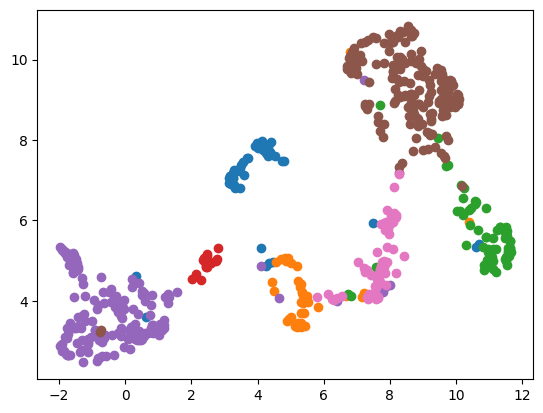

====> Epoch: 23 Average loss: 31.1854
====> Epoch: 23 Average Test loss: 37.9200


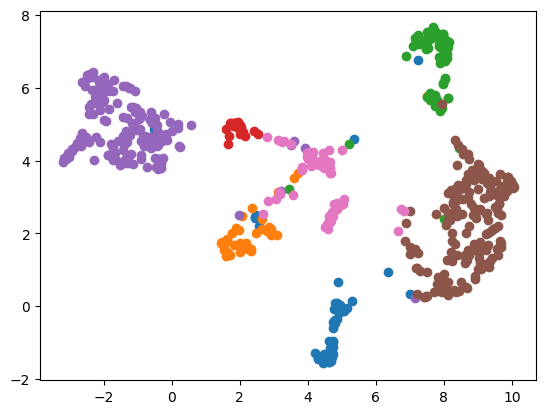

====> Epoch: 24 Average loss: 30.8376
====> Epoch: 24 Average Test loss: 37.7039


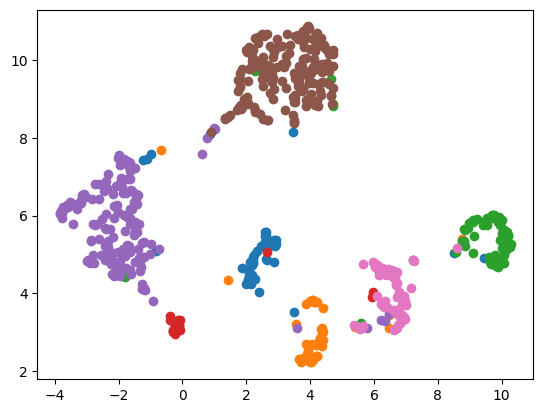

====> Epoch: 25 Average loss: 30.5182
====> Epoch: 25 Average Test loss: 38.2069


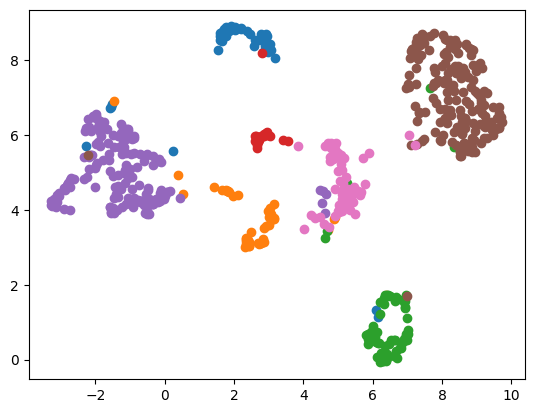

====> Epoch: 26 Average loss: 30.2421
====> Epoch: 26 Average Test loss: 38.0383


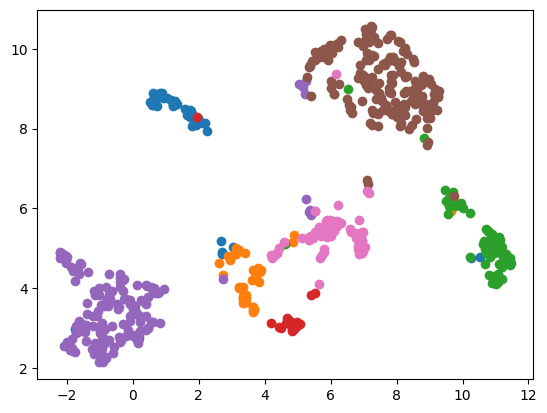

====> Epoch: 27 Average loss: 29.8880
====> Epoch: 27 Average Test loss: 38.1377


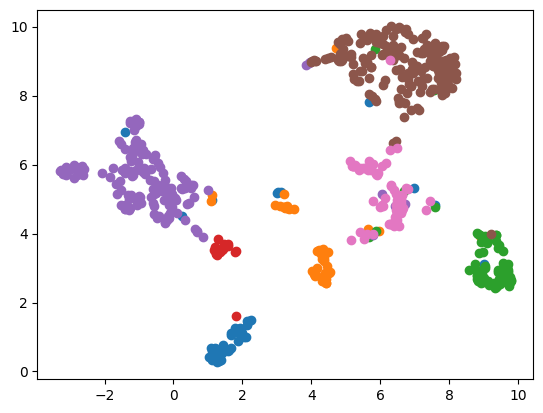

====> Epoch: 28 Average loss: 29.5252
====> Epoch: 28 Average Test loss: 38.0655


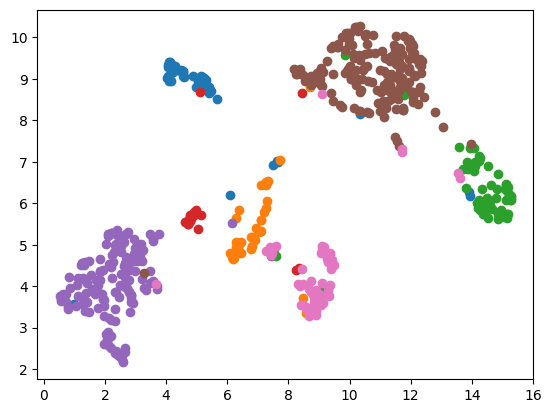

====> Epoch: 29 Average loss: 29.2700
====> Epoch: 29 Average Test loss: 38.5087


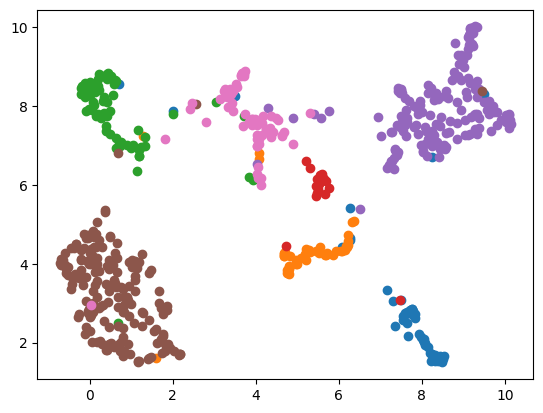

====> Epoch: 30 Average loss: 28.8915
====> Epoch: 30 Average Test loss: 38.6751


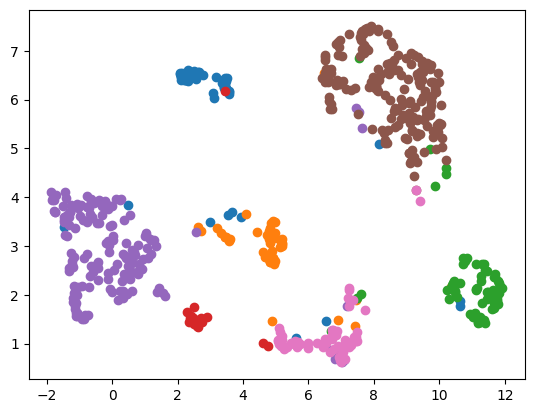

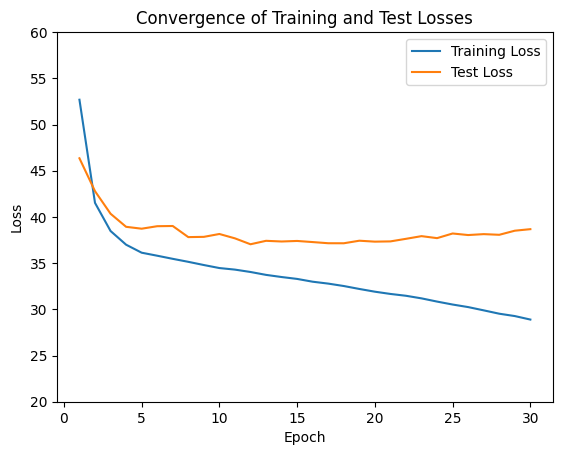

torch.Size([25, 18879])


In [669]:
#Train the model
epochs = 30
train_losses = []
test_losses = []
min_test_loss = float('inf')
for epoch in range(0, epochs + 1):
     if epoch > 0:
        model.train()
        train_loss = 0
        for x,_ in train_loader:
             x = x.to(device)
             x_recon, mu, logvar = model(x)
             loss = loss_function(x, x_recon, mu, logvar)
             train_loss += loss.item()/x.size(0)
             optimizer.zero_grad()
             loss.backward()
             optimizer.step()
        train_losses.append(train_loss / len(train_dataset))    
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_dataset):.4f}')

           
#Test the Model
        def test_vae(model, test_loader, device, loss_function):
          with torch.no_grad():
            model.eval()
            test_loss = 0
            reconstruction = []
            mus = []
            logvars = []
            labels = []
            for x,y in test_loader:
              x = x.to(device)
              x_recon,mu,logvar = model(x)
              loss = loss_function(x, x_recon, mu, logvar)
              test_loss += loss.item()/x.size(0)
              reconstruction.append(x_recon.cpu().detach().numpy())
              mus.append(mu.cpu().detach().numpy())
              logvars.append(logvar.cpu().detach().numpy())
              labels.append(y.cpu().detach().numpy())
            test_loss /= len(test_dataset)
            return test_loss,reconstruction,mus,logvars 
   
        test_loss, reconstruction, mus, logvars = test_vae(model, test_loader, device, loss_function)
        test_losses.append(test_loss)  
        #Save the best weight
        if test_loss < min_test_loss:
          min_test_loss = test_loss
          best_epoch = epoch
          best_weights2 = model.state_dict()
          torch.save(model.state_dict(),"best_model_weights.pth2")
        print(f'====> Epoch: {epoch} Average Test loss: {test_loss:.4f}')

#Extract Latent
        model.eval()
        latent = []
        labels = []
        with torch.no_grad():
          for x,y in test_loader:
            x = x.to(device)
            x_recon, mu, logvar = model.forward(x)
            # Sample z using the reparameterization trick
            z = model.reparameterise(mu, logvar)
            labels.append(y.cpu().detach().numpy())
            latent.append(z)

#UMAP for visualizing in 2D

          latent_1 = torch.cat(latent,dim=0)
          latent_2 = latent_1.cpu().numpy()
          fit = umap.UMAP()
          embeddings = fit.fit_transform(latent_2)
          unique_labels = np.unique(np.concatenate(labels))
          for label in unique_labels:
            indices = np.where(np.concatenate(labels) == label)
            plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=label)

          plt.show()  
       
#Plot the Convergence
print("\n")
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Convergence of Training and Test Losses")
plt.ylim(20, 60) 
plt.show()
print(x.shape)

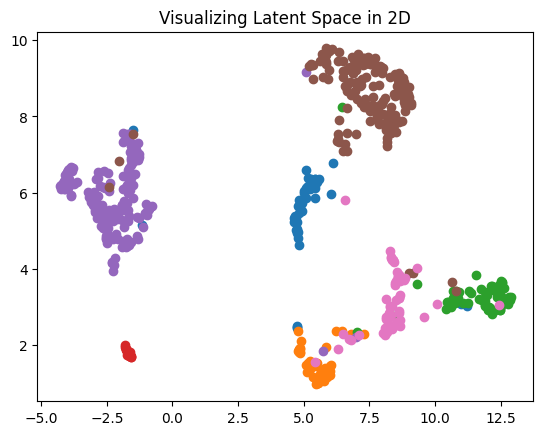

Average test loss at best weights: 37.3376608484557


In [681]:
#Load the neural networks with best weights and plot the latent space
model.load_state_dict(torch.load("best_model_weights.pth2"))
model.eval()
test_loss=0
latent = []
labels = []
with torch.no_grad():  
    for x, y in test_loader:
      x = x.to(device)
      x_recon,mu,logvar = model(x)
      loss = loss_function(x, x_recon, mu, logvar)
      labels.append(y.clone().detach().numpy())
      z = model.reparameterise(mu, logvar)
      latent.append(z)
      test_loss += loss.item()/x.size(0)
avg_test_loss = test_loss / len(test_dataset)
latent_1 = torch.cat(latent,dim=0)
latent_2 = latent_1.cpu().numpy()

fit = umap.UMAP()
embeddings = fit.fit_transform(latent_2)
unique_labels = np.unique(np.concatenate(labels))
for label in unique_labels:
  indices = np.where(np.concatenate(labels) == label)
  plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=label)
  plt.title("Visualizing Latent Space in 2D")

plt.show()
print(f'Average test loss at best weights: {avg_test_loss}') 

**6.3 Run K-means**

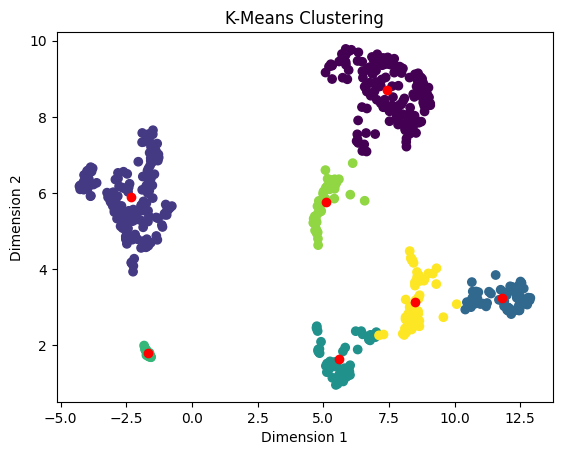

In [682]:
#K-means Implementation 
num_clusters = 7

kmeans= KMeans(
    n_clusters=num_clusters, n_init=10).fit(embeddings)

plt.scatter(embeddings[:,0],embeddings[:,1],c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c = "red")

plt.title("K-Means Clustering")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

**6.4 Compute ARI Score along with its mean and standard deviation(weighted HVGs)**

In [672]:
n_runs = 20
ari_score = []
num_clusters = 7
warnings.filterwarnings("ignore")
for _ in range(n_runs):
  model.load_state_dict(torch.load("best_model_weights.pth2"))
  model.eval()
  test_loss=0
  latent = []
  labels = []
  with torch.no_grad():  
      for x, y in test_loader:
        x = x.to(device)
        x_recon,mu,logvar = model(x)
        labels.append(y.clone().detach().numpy())
        z = model.reparameterise(mu, logvar)
        latent.append(z)
  latent_1 = torch.cat(latent,dim=0)
  latent_2 = latent_1.cpu().numpy()
  fit = umap.UMAP()
  embeddings = fit.fit_transform(latent_2)
  labels_np=np.concatenate(labels)
  kmeans= KMeans(
      n_clusters=num_clusters, n_init=10).fit(embeddings)
  ari=adjusted_rand_score(kmeans.labels_,labels_np)
  ari_score.append(ari)

ari_score = np.array(ari_score)
mean_ari = np.mean(ari_score)
std_ari = np.std(ari_score)

print(f"Average ARI over {n_runs} runs: {mean_ari}")
print(f"Standard deviation of ARI over {n_runs} runs: {std_ari}")

Average ARI over 20 runs: 0.7696478478567481
Standard deviation of ARI over 20 runs: 0.0602815424976532


## After giving more weights on HVGs when computing the reconstruction loss, I have oberved an improvment in the ARI score of ***0.77***, which is significantly higher than the previous time. This suggests that increased emphasis on HVGs helped captured more meaningful patterns and structrue in data.

# 7.ARI Further Improvement

**7.1 Method: Apply Gaussian Mixture Models (GMMs) as alternatives to K-means clustering**

Using Guassian Mixture Models(GMMs) to perform clustering the latent representation produced by Variantional Autoencoder trained on weighted HVGs.

**7.2 Run Gaussian Mixture Models**

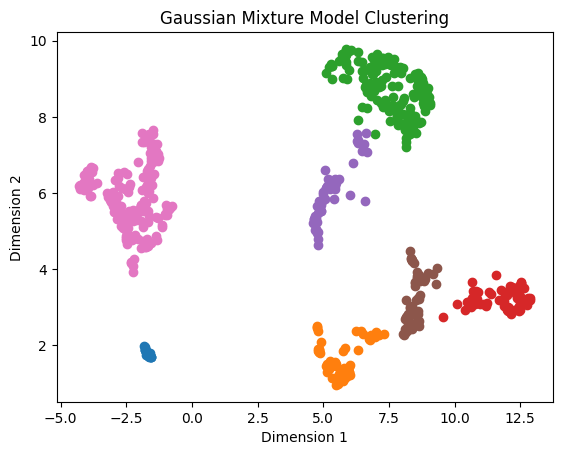

In [684]:
#Implement Gaussian Mixture Models
from sklearn.mixture import GaussianMixture
n_components = 7
gmm = GaussianMixture(n_components=n_components, n_init=20)
gmm.fit(embeddings)
labels_Gmms = gmm.predict(embeddings)

for i in range(n_components):
    plt.scatter(embeddings[labels_Gmms == i, 0], embeddings[labels_Gmms == i, 1], label='Cluster ' + str(i+1))
plt.title("Gaussian Mixture Model Clustering")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


**7.5 ARI Score along with its mean and standard deviation(GMMs weighted HGVs)**

In [675]:
n_runs = 20
ari_score = []
n_components = 7
warnings.filterwarnings("ignore")
for _ in range(n_runs):
  model.load_state_dict(torch.load("best_model_weights.pth2"))
  model.eval()
  latent = []
  labels = []
  with torch.no_grad():  
      for x, y in test_loader:
        x = x.to(device)
        x_recon,mu,logvar = model(x)
        labels.append(y.clone().detach().numpy())
        z = model.reparameterise(mu, logvar)
        latent.append(z)
  latent_1 = torch.cat(latent,dim=0)
  latent_2 = latent_1.cpu().numpy()
  fit = umap.UMAP()
  embeddings = fit.fit_transform(latent_2)
  labels_np=np.concatenate(labels)
  gmm = GaussianMixture(n_components=n_components, n_init=20)
  gmm.fit(embeddings)
  labels_Gmms = gmm.predict(embeddings)
  ari=adjusted_rand_score(labels_Gmms,labels_np)
  ari_score.append(ari)

ari_score = np.array(ari_score)
mean_ari = np.mean(ari_score)
std_ari = np.std(ari_score)

print(f"Average ARI over {n_runs} runs: {mean_ari}")
print(f"Standard deviation of ARI over {n_runs} runs: {std_ari}")



Average ARI over 20 runs: 0.8424956613773045
Standard deviation of ARI over 20 runs: 0.0669543009470336


# The Performance of GMMs is better than K-means.The ARI score is ***0.84***, which is relevently higher for Gaussian Mixture Models (GMMs) compared to K-means clustering.

# Conclusion: 


*   ARI score with K-means:    
   ***0.67***

*   ARI score with K-means(VAE trained on weighted HVGs):

   ***0.77***

*   ARI score with GMMs(VAE trained on weighted HVGs):

   ***0.84***


